<a href="https://colab.research.google.com/github/yosrkharrat/img_captionning/blob/main/img_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1.1: Install and import dependencies
!pip install kagglehub torch torchvision nltk pillow matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import kagglehub
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Step 1.2: Download dataset
path = kagglehub.dataset_download("ming666/flicker8k-dataset")
print("Dataset path:", path)

# Define paths
IMAGE_DIR = os.path.join(path, "Flickr8k_Dataset/Flicker8k_Dataset")
CAPTION_FILE = os.path.join(path, "Flickr8k_text/Flickr8k.token.txt")
TRAIN_IMAGES = os.path.join(path, "Flickr8k_text/Flickr_8k.trainImages.txt")
DEV_IMAGES = os.path.join(path, "Flickr8k_text/Flickr_8k.devImages.txt")
TEST_IMAGES = os.path.join(path, "Flickr8k_text/Flickr_8k.testImages.txt")

100%|██████████| 2.08G/2.08G [00:21<00:00, 104MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/ming666/flicker8k-dataset/versions/1


In [ ]:
# Step 1.3: Load and parse captions
def load_captions(caption_file):
    """
    Each line format: image_name#caption_number\tcaption_text
    Example: 1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs
    """
    captions_dict = {}
    with open(caption_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            image_caption_id, caption = parts
            image_name = image_caption_id.split('#')[0]

            if image_name not in captions_dict:
                captions_dict[image_name] = []
            captions_dict[image_name].append(caption)
    return captions_dict

captions_dict = load_captions(CAPTION_FILE)
print(f"Total images with captions: {len(captions_dict)}")
print(f"\nSample image captions:")
sample_img = list(captions_dict.keys())[0]
print(f"{sample_img}:")
for i, cap in enumerate(captions_dict[sample_img]):
    print(f"  {i+1}. {cap}")

Total images with captions: 8092

Sample image captions:
1000268201_693b08cb0e.jpg:
  1. A child in a pink dress is climbing up a set of stairs in an entry way .
  2. A girl going into a wooden building .
  3. A little girl climbing into a wooden playhouse .
  4. A little girl climbing the stairs to her playhouse .
  5. A little girl in a pink dress going into a wooden cabin .


In [ ]:
def load_image_list(file_path):
  with open(file_path, 'r') as f:
    return [line.strip() for line in f]
train_images = set(load_image_list(TRAIN_IMAGES))
dev_images = set(load_image_list(DEV_IMAGES))
test_images = set(load_image_list(TEST_IMAGES))

print(f"Train images: {len(train_images)}")
print(f"Dev images: {len(dev_images)}")
print(f"Test images: {len(test_images)}")

Train images: 6000
Dev images: 1000
Test images: 1000


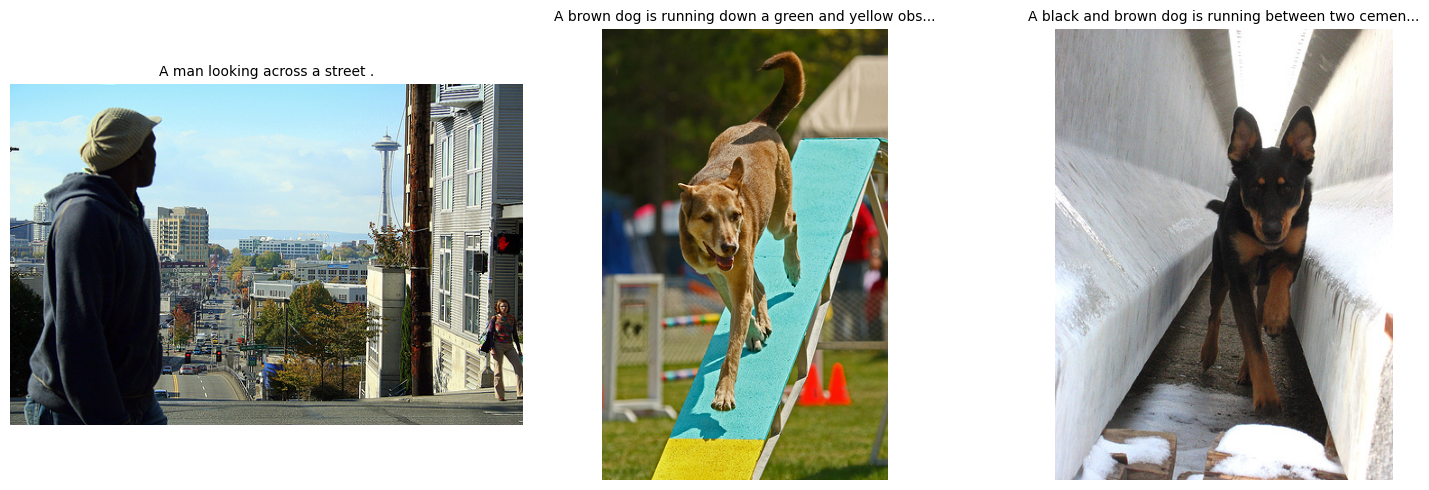

In [ ]:
def visualize_samples(image_dir, captions_dict , image_list, n=3):
  fig, axes=plt.subplots(1,n,figsize=(15,5))
  for i , img_name in enumerate(list(image_list)[:n]):
    img_path=os.path.join(image_dir,img_name)
    img=Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

    caption=captions_dict[img_name][0]
    axes[i].set_title(caption[:50] + "..." if len(caption) > 50 else caption,
                         fontsize=10, wrap=True)
  plt.tight_layout()
  plt.show()

visualize_samples(IMAGE_DIR, captions_dict, train_images)

Text Preprocessing (building vocab)

In [ ]:
import re

def clean_caption(caption):
  caption = caption.lower()
  caption = re.sub(r'[^a-z\s]', '', caption)
  caption = re.sub(r'\s+', ' ', caption).strip()
  return caption

cleaned_captions = {}
for img_name, caps in captions_dict.items():
    cleaned_captions[img_name] = [clean_caption(cap) for cap in caps]

print("Original:", captions_dict[sample_img][0])
print("Cleaned:", cleaned_captions[sample_img][0])

Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Cleaned: a child in a pink dress is climbing up a set of stairs in an entry way


In [ ]:
class Vocabulary:
  def __init__(self, freq_threshold=5):
    self.freq_threshold = freq_threshold
    self.word2idx = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
    self.idx2word = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
    self.word_freq = Counter()

  def build_vocabulary(self, captions_list):
    idx=4
    for caption in captions_list:
      tokens=caption.split()
      self.word_freq.update(tokens)

    for word, freq in self.word_freq.items():
      if freq>= self.freq_threshold:
        self.word2idx[word]=idx
        self.idx2word[idx]=word
        idx+=1

    print(f"Vocabulary size: {len(self.word2idx)}")
    print(f"Most common words: {self.word_freq.most_common(10)}")

  def __len__(self):
    return len(self.word2idx)

  def numericalize(self, text):
    tokens=text.split()
    return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]



# Build vocabulary on training captions only (avoid data leakage)
train_captions_list = []
for img_name in train_images:
    if img_name in cleaned_captions:
        train_captions_list.extend(cleaned_captions[img_name])

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(train_captions_list)


Vocabulary size: 2535
Most common words: [('a', 46781), ('in', 14085), ('the', 13509), ('on', 8006), ('is', 6907), ('and', 6672), ('dog', 6159), ('with', 5763), ('man', 5374), ('of', 4967)]


Dataset and dataloader

Image tranformation

In [ ]:
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

Custom dataset

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions_dict, image_list, vocab, transform=None):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.vocab = vocab
        self.transform = transform

        # Creating (image, caption) pairs
        self.data = []
        for img_name in image_list:
            if img_name in captions_dict:
                for caption in captions_dict[img_name]:
                    self.data.append((img_name, caption))

        print(f"Dataset size: {len(self.data)} (image, caption) pairs")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]

        # Loading image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenizing caption (add START and END tokens)
        caption_tokens = [self.vocab.word2idx["<START>"]]
        caption_tokens.extend(self.vocab.numericalize(caption))
        caption_tokens.append(self.vocab.word2idx["<END>"])

        return image, torch.tensor(caption_tokens)

# Create datasets
train_dataset = FlickrDataset(IMAGE_DIR, cleaned_captions, train_images,
                              vocab, transform=train_transform)
val_dataset = FlickrDataset(IMAGE_DIR, cleaned_captions, dev_images,
                            vocab, transform=val_transform)

Dataset size: 30000 (image, caption) pairs
Dataset size: 5000 (image, caption) pairs


Collate function for variable length captions

In [ ]:
def collate_fn(batch):
    """
    Batch is list of (image, caption) tuples
    Captions have different lengths → need padding
    """
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)

    # Pad captions to max length in batch
    lengths = [len(cap) for cap in captions]
    max_len = max(lengths)

    padded_captions = torch.zeros(len(captions), max_len).long()
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap

    return images, padded_captions, torch.tensor(lengths)


#dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=collate_fn)
#test dataloader
images, captions, lengths = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Caption batch shape: {captions.shape}")
print(f"Lengths: {lengths[:5]}")


Image batch shape: torch.Size([32, 3, 224, 224])
Caption batch shape: torch.Size([32, 22])
Lengths: tensor([13, 10, 12, 16, 14])


Model architecture

Encoder (CNN feature extractor)

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Use pre-trained ResNet50, remove final classification layer,
        add linear layer to project features to embedding space
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Remove last FC layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Freeze CNN weights (don't update during training)
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Project 2048-dim ResNet features to embed_size
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        """
        Input: (batch_size, 3, 224, 224)
        Output: (batch_size, embed_size)
        """
        features = self.resnet(images)  # (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # (batch_size, 2048)
        features = self.bn(self.linear(features))  # (batch_size, embed_size)
        return features

Decoder (LSTM caption generator)

In [ ]:
class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        embed_size: size of word embeddings and image features
        hidden_size: LSTM hidden state size
        vocab_size: number of words in vocabulary
        """
        super(DecoderLSTM, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions, lengths):
        """
        features: (batch_size, embed_size) from encoder
        captions: (batch_size, max_length) tokenized captions
        lengths: actual lengths before padding
        """
        # Embed captions
        embeddings = self.embed(captions)  # (batch_size, max_length, embed_size)

        # Concatenate image features as first "word"
        features = features.unsqueeze(1)  # (batch_size, 1, embed_size)
        inputs = torch.cat([features, embeddings], dim=1)  # (batch_size, max_length+1, embed_size)

        # Pack padded sequence (efficiency for variable lengths)
        packed = nn.utils.rnn.pack_padded_sequence(
            inputs, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM forward pass
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(self.dropout(hiddens.data))

        return outputs

    def sample(self, features, max_length=20):
        """
        Generate caption word-by-word (inference mode)
        """
        result = []
        states = None
        inputs = features.unsqueeze(1)  # (1, 1, embed_size)

        for _ in range(max_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            result.append(predicted.item())

            # Stop if <END> token generated
            if predicted.item() == vocab.word2idx["<END>"]:
                break

            # Next input is predicted word embedding
            inputs = self.embed(predicted).unsqueeze(1)

        return result

Training loop

In [ ]:
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

encoder = EncoderCNN(EMBED_SIZE).to(device)
decoder = DecoderLSTM(EMBED_SIZE, HIDDEN_SIZE, len(vocab), NUM_LAYERS).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 93.4MB/s]


Training fct

In [ ]:
# Step 5.2: Training function (FIXED)
def train_epoch(encoder, decoder, loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, (images, captions, lengths) in enumerate(loader):
        images = images.to(device)
        captions = captions.to(device)

        # IMPORTANT FIX: Adjust lengths to account for excluding last token
        # Original lengths include <START> ... <END>
        # We need lengths for input which is <START> ... (excluding <END>)
        adjusted_lengths = lengths - 1  # Subtract 1 because we exclude last token

        # Filter out any sequences that would be empty after adjustment
        valid_mask = adjusted_lengths > 0
        if not valid_mask.all():
            images = images[valid_mask]
            captions = captions[valid_mask]
            adjusted_lengths = adjusted_lengths[valid_mask]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1], adjusted_lengths)

        # Calculate loss
        # Targets are the actual next words (excluding <START>)
        targets = nn.utils.rnn.pack_padded_sequence(
            captions[:, 1:], adjusted_lengths.cpu(), batch_first=True, enforce_sorted=False
        ).data

        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")

    return total_loss / len(loader)

Valdation fct

In [ ]:
# Step 5.3: Validation function (FIXED)
def validate(encoder, decoder, loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions, lengths in loader:
            images = images.to(device)
            captions = captions.to(device)

            # Same fix as training
            adjusted_lengths = lengths - 1

            # Filter out any sequences that would be empty
            valid_mask = adjusted_lengths > 0
            if not valid_mask.all():
                images = images[valid_mask]
                captions = captions[valid_mask]
                adjusted_lengths = adjusted_lengths[valid_mask]

            features = encoder(images)
            outputs = decoder(features, captions[:, :-1], adjusted_lengths)

            targets = nn.utils.rnn.pack_padded_sequence(
                captions[:, 1:], adjusted_lengths.cpu(), batch_first=True, enforce_sorted=False
            ).data

            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(loader)

Training loop


Epoch 1/10
Batch 0/938, Loss: 7.8323
Batch 100/938, Loss: 5.1615
Batch 200/938, Loss: 4.8803
Batch 300/938, Loss: 4.6802
Batch 400/938, Loss: 4.0291
Batch 500/938, Loss: 4.2855
Batch 600/938, Loss: 4.4467
Batch 700/938, Loss: 3.9551
Batch 800/938, Loss: 4.0886
Batch 900/938, Loss: 4.3410
Train Loss: 4.6056
Val Loss: 4.0955
✓ Saved best model

Epoch 2/10
Batch 0/938, Loss: 4.0628
Batch 100/938, Loss: 4.1898
Batch 200/938, Loss: 4.2076
Batch 300/938, Loss: 4.2335
Batch 400/938, Loss: 4.0626
Batch 500/938, Loss: 3.7831
Batch 600/938, Loss: 3.8991
Batch 700/938, Loss: 4.1847
Batch 800/938, Loss: 4.1531
Batch 900/938, Loss: 4.1539
Train Loss: 4.0041
Val Loss: 3.8582
✓ Saved best model

Epoch 3/10
Batch 0/938, Loss: 3.8005
Batch 100/938, Loss: 4.0944
Batch 200/938, Loss: 3.8979
Batch 300/938, Loss: 3.9824
Batch 400/938, Loss: 3.7894
Batch 500/938, Loss: 3.8669
Batch 600/938, Loss: 3.5973
Batch 700/938, Loss: 3.5267
Batch 800/938, Loss: 3.4704
Batch 900/938, Loss: 3.8965
Train Loss: 3.7915
V

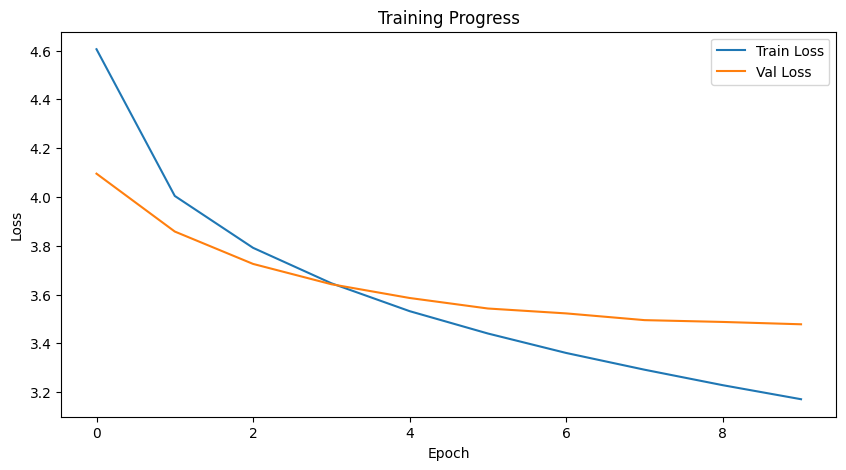

In [ ]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*50}")

    train_loss = train_epoch(encoder, decoder, train_loader, criterion, optimizer, device)
    val_loss = validate(encoder, decoder, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss == min(val_losses):
        torch.save({
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'vocab': vocab
        }, 'best_model.pth')
        print("✓ Saved best model")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

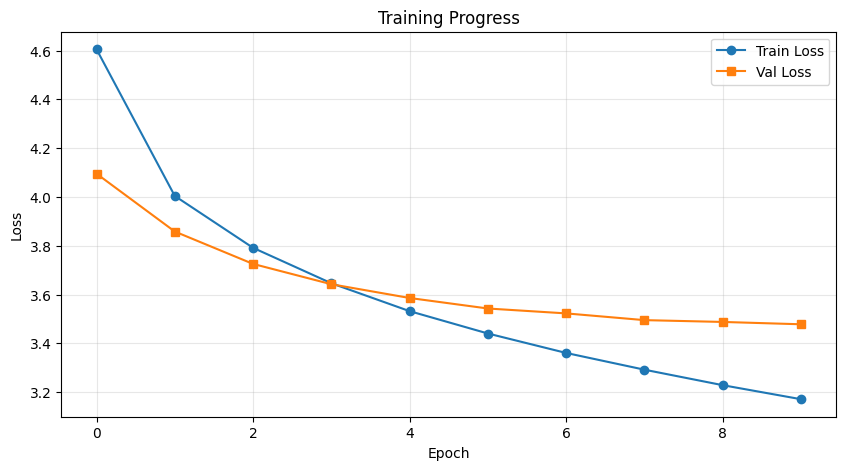

Final Train Loss: 3.1708
Final Val Loss: 3.4780
Best Val Loss: 3.4780 (Epoch 10)


In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Best Val Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")

PREDICTIONS ON TEST SET (Never seen during training)


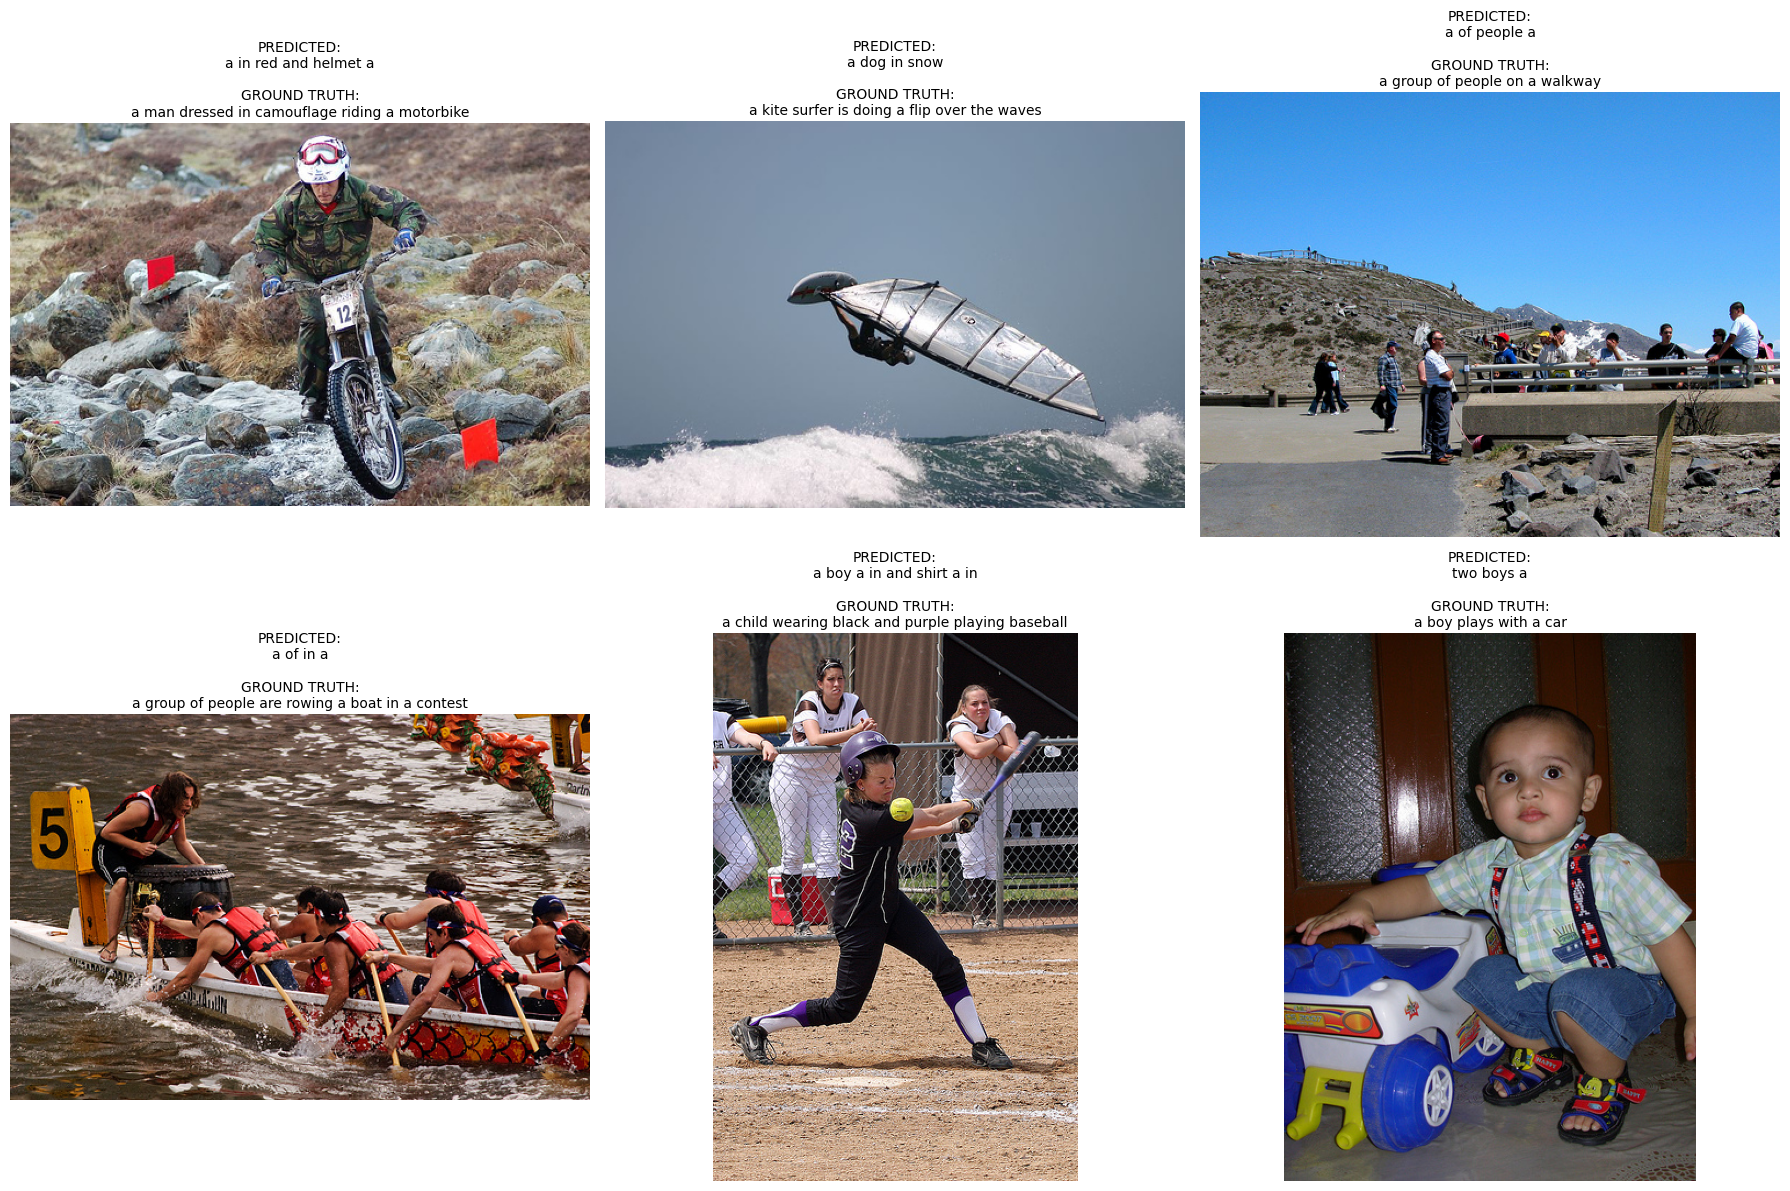

In [ ]:
# Generate captions for test images
def show_predictions(image_dir, image_list, encoder, decoder, vocab, transform, device, n=6):
    """Display images with predicted and ground truth captions"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Convert image_list to list if it's a set
    image_list = list(image_list)

    for i in range(min(n, len(image_list))):
        img_name = image_list[i]
        img_path = os.path.join(image_dir, img_name)

        # Generate caption
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(image_tensor)
            caption_indices = decoder.sample(features, max_length=20)

        # Convert indices to words
        predicted_caption = []
        for idx in caption_indices:
            word = vocab.idx2word[idx]
            if word == "<END>":
                break
            if word not in ["<START>", "<PAD>", "<UNK>"]:
                predicted_caption.append(word)

        predicted_caption = ' '.join(predicted_caption)

        # Get ground truth
        if img_name in cleaned_captions:
            gt_caption = cleaned_captions[img_name][0]
        else:
            gt_caption = "N/A"

        # Display
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(
            f"PREDICTED:\n{predicted_caption}\n\nGROUND TRUTH:\n{gt_caption}",
            fontsize=10,
            ha='center',
            wrap=True
        )

    plt.tight_layout()
    plt.show()

# Show predictions on test set
print("=" * 60)
print("PREDICTIONS ON TEST SET (Never seen during training)")
print("=" * 60)
show_predictions(IMAGE_DIR, test_images, encoder, decoder, vocab, val_transform, device, n=6)


MORE RANDOM TEST EXAMPLES


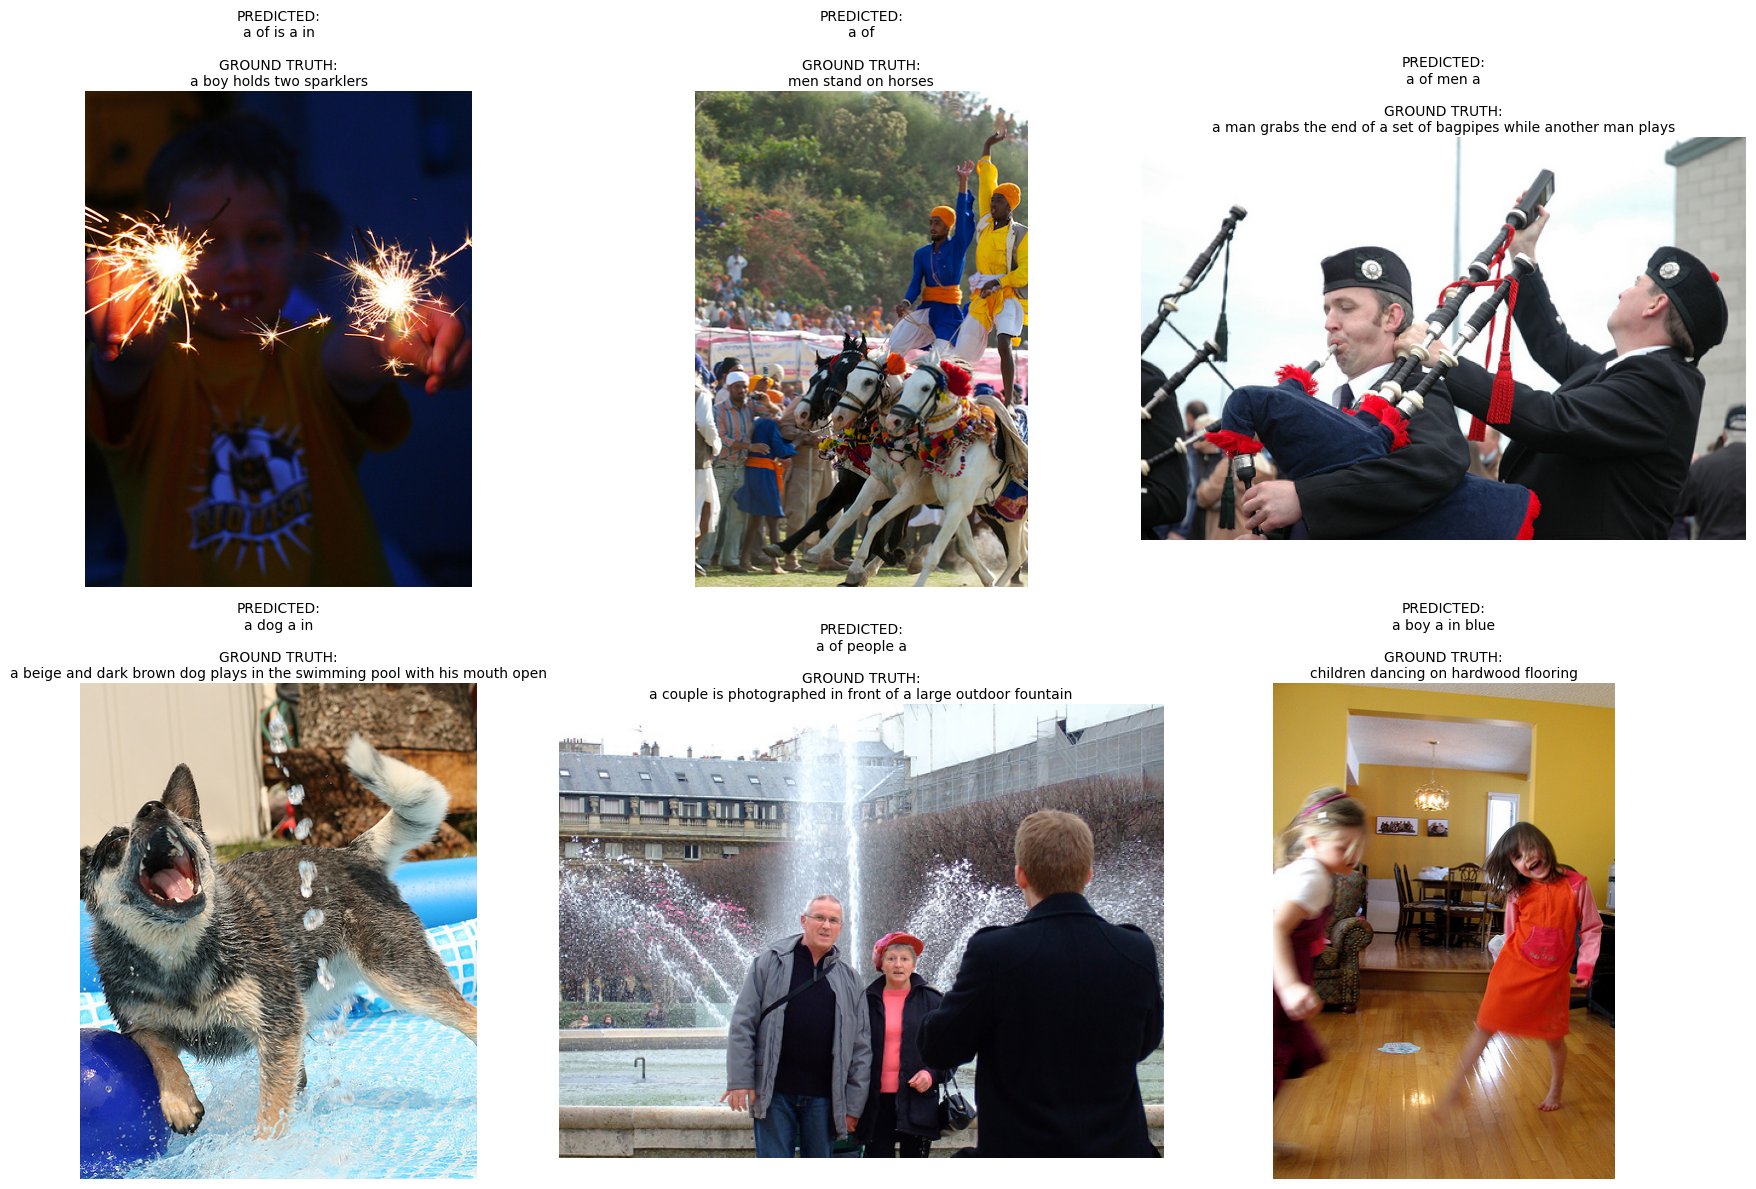

In [ ]:
# Show more diverse examples
import random

# Sample random test images
random_test_images = random.sample(list(test_images), 6)

print("\n" + "=" * 60)
print("MORE RANDOM TEST EXAMPLES")
print("=" * 60)
show_predictions(IMAGE_DIR, random_test_images, encoder, decoder, vocab, val_transform, device, n=6)